# Exploratory Analysis of TheMoviesDataset

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

# Import new libraries
import wordcloud
from wordcloud import WordCloud, STOPWORDS

### Functions and Procedures for gathering data and condensing them into a dataframe

In [47]:

# Define file directories
MOVIES_DATA_DIR = './data/'
MOVIES_CBR_CSV_FILE = MOVIES_DATA_DIR + 'movies_cbr_small.csv'
RATING_SCALE_CSV_FILE = MOVIES_DATA_DIR + 'ratings_scale_small.csv'

def get_expinfodf_by_genre(movies_cbr_small):
    expinfo_dict_by_genre = {}
    for i in range(movies_cbr_small.shape[0]):
        for genre in str(movies_cbr_small.iloc[i]['genres']).split('|'):
            genre_name = genre
            if genre != 'nan' and genre is not np.nan:
                if movies_cbr_small.iloc[i]['revenue'] is not np.nan and movies_cbr_small.iloc[i]['budget'] is not np.nan and float(movies_cbr_small.iloc[i]['budget']) > 0 and float(movies_cbr_small.iloc[i]['revenue']) > 0.0:
                    total_revenue_mill = round(float(movies_cbr_small.iloc[i]['revenue']) / 1000000,2)
                    total_budget_mill = round(float(movies_cbr_small.iloc[i]['budget']) / 1000000,2)
                else:
                    total_revenue_mill = 0
                    total_budget_mill = 0

                if movies_cbr_small.iloc[i]['runtime'] is not np.nan and float(movies_cbr_small.iloc[i]['runtime']) > 0.0:
                    total_runtime_min = round(float(movies_cbr_small.iloc[i]['runtime']),2)
                else:
                    total_runtime_min = 0

                if genre_name in expinfo_dict_by_genre:
                    expinfo_dict_by_genre[genre_name]['total_revenue_mill'] += total_revenue_mill
                    expinfo_dict_by_genre[genre_name]['total_budget_mill'] += total_budget_mill
                    expinfo_dict_by_genre[genre_name]['movies_count_rb'] += 1
                    expinfo_dict_by_genre[genre_name]['total_runtime_min'] += total_runtime_min
                    expinfo_dict_by_genre[genre_name]['movies_count_rt'] += 1
                    expinfo_dict_by_genre[genre_name]['movies_count_genre'] += 1
                else:
                    expinfo_dict_by_genre[genre_name] = {}
                    expinfo_dict_by_genre[genre_name]['total_revenue_mill'] = total_revenue_mill
                    expinfo_dict_by_genre[genre_name]['total_budget_mill'] = total_budget_mill
                    expinfo_dict_by_genre[genre_name]['movies_count_rb'] = 1
                    expinfo_dict_by_genre[genre_name]['total_runtime_min'] = total_runtime_min
                    expinfo_dict_by_genre[genre_name]['movies_count_rt'] = 1
                    expinfo_dict_by_genre[genre_name]['movies_count_genre'] = 1
    
    expinfodf_by_genre = pd.DataFrame(None,None,columns=[
        'Genre',
        'Movie_Count_Genre',
        'Average_Revenue',
        'Average_Budget',
        'Movies_Count_RB',
        'Average_Runtime',
        'Movies_Count_RT',
    ])

    for k,v in expinfo_dict_by_genre.items():
        expinfodf_by_genre =  expinfodf_by_genre.append({'Genre':k,
                                                         'Movie_Count_Genre': v['movies_count_genre'],
                                                         'Average_Revenue' : round(v['total_revenue_mill']/v['movies_count_rb'],2),
                                                         'Average_Budget' : round(v['total_budget_mill']/v['movies_count_rb'],2),
                                                         'Movies_Count_RB' : v['movies_count_rb'],
                                                         'Average_Runtime' : round(v['total_runtime_min']/v['movies_count_rt'],2),
                                                         'Movies_Count_RT' : v['movies_count_rt']
                                                                  },ignore_index=True)

    return expinfodf_by_genre

def load_movie_ratings(ratings_scale_small_filepath):
    #Load movieswithratings & create movies dataframe
    df = pd.read_csv(ratings_scale_small_filepath, dtype='unicode')
    #convert df["id"] datatype from object to int (int64)
    df["rating"] = df["rating"].astype(str).astype(float)
    df["movieId"] = df["movieId"].astype(str).astype('int64')
    df["userId"] = df["userId"].astype(str).astype('int64')
    return df

def load_preprocess_movies_cbr_small(movies_cbr_small_filepath):
    movies_cbr_small = pd.read_csv(movies_cbr_small_filepath, dtype='unicode')
    movies_cbr_small["tmdbid"] = movies_cbr_small["tmdbid"].astype(str).astype('int64')
    movies_cbr_small["imdbid"] = movies_cbr_small["tmdbid"].astype(str).astype('int64')
    movies_cbr_small["budget"] = movies_cbr_small["budget"].astype(str).astype('int64')
    movies_cbr_small["revenue"] = movies_cbr_small["revenue"].astype(str).astype('int64')
    movies_cbr_small["runtime"] = movies_cbr_small["runtime"].astype(str).astype(float)
    movies_cbr_small["vote_average"] = movies_cbr_small["vote_average"].astype(str).astype(float)
    movies_cbr_small["vote_count"] = movies_cbr_small["vote_count"].astype(str).astype('int64')
    movies_cbr_small['release_date'] = pd.to_datetime(movies_cbr_small['release_date'])
    movies_cbr_small = movies_cbr_small.loc[(movies_cbr_small.budget > 0) & (movies_cbr_small.revenue > 0),:]
    return movies_cbr_small

def get_moviescount_for_wordcloud(df):
    return df.set_index('Genre').to_dict()['Movie_Count_Genre']



### Creation of Datasets

In [48]:

#load & create ratings scale dataframe
ratingsdf = load_movie_ratings(RATING_SCALE_CSV_FILE)

#get movies dataframe
movies_cbr_small = load_preprocess_movies_cbr_small(MOVIES_CBR_CSV_FILE)

#create exploratory information by genre for movies count, average budget, average revenue 
#and avergae runtime
expinfodf_by_genre = get_expinfodf_by_genre(movies_cbr_small)


# Ratings Dataset
This is a dataframe consisting of ratings(1-5) and a scale(poor-excellent) for each movie. The movies are identified by the movieID, and the user ratings are identified by the userID. 

In [49]:
ratingsdf.sort_values('sortOrder')

,Unnamed: 0,userId,movieId,rating,timestamp,scale,sortOrder
45000,45000,315,5944,1.0,1046663723,Poor (0-1),1
10538,10538,73,1826,1.0,1255588837,Poor (0-1),1
28221,28221,207,3991,0.5,1258440380,Poor (0-1),1
72380,72380,509,377,1.0,940013699,Poor (0-1),1
44516,44516,312,1527,1.0,959931593,Poor (0-1),1
...,...,...,...,...,...,...,...
74825,74825,519,3307,5.0,1463338910,Excellent (4-5),5
31427,31427,228,1196,5.0,1449332248,Excellent (4-5),5
31428,31428,228,1197,5.0,1449332705,Excellent (4-5),5
74836,74836,519,4979,4.5,1468927277,Excellent (4-5),5


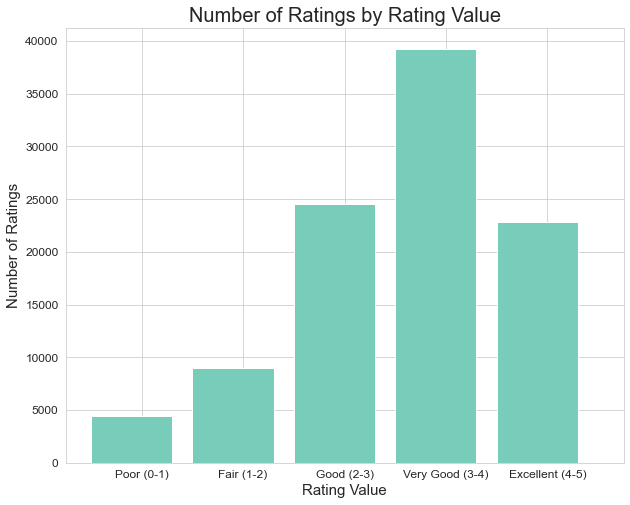

In [50]:
# Exploratory Analysis
ratingsdf = ratingsdf.sort_values('sortOrder',ascending=True)

plt.figure(figsize=[10,8])
plt.hist(ratingsdf['scale'],width=0.8,align='left',bins=range(6),color='#78CDBA')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Rating Value',fontsize=15)
plt.ylabel("Number of Ratings",fontsize=15)
plt.title('Number of Ratings by Rating Value',fontsize=20)
plt.show()

This is a histogram analysis that takes in the number of user ratings based off of the rating value itself. The data has been grouped into 5 categories with range of a rating values in each one. From the histogram, we can see that most users give a very good rating(3-4), regardless of the movie. This means that more people give a rating when they believe a movie deserves a value within that range. It could also mean that any value within this range is the most popular option to rate for most users. Good(2-3) and excellent(4-5) ratings result in a similar number of total ratings of just under 25,000. Poor(0-1) and Fair(1-2) ratings have the lowest total ratings in the data. So if a movie is poor or fair, chances are the user will not even give a rating, which is why the total ratings for these categories are so low.

# Genres Dataset
This dataframe contains the information for the rest of the analysis. Based on genre, all of the values give an average value, or a total count. 

In [51]:
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Movie_Count_Genre',ascending=False)
expinfodf_by_genre.head(25)

,Genre,Movie_Count_Genre,Average_Revenue,Average_Budget,Movies_Count_RB,Average_Runtime,Movies_Count_RT
5,Drama,2583,57.97,22.38,2583,115.90,2583
1,Comedy,1851,83.52,28.25,1851,102.35,1851
9,Thriller,1502,83.89,32.36,1502,109.67,1502
7,Action,1414,139.01,49.73,1414,112.91,1414
6,Romance,1013,66.88,21.38,1013,113.57,1013
3,Adventure,957,205.00,63.87,957,113.04,957
8,Crime,861,69.92,27.98,861,110.95,861
11,Science Fiction,634,152.31,52.35,634,107.97,634
13,Horror,586,50.86,16.38,586,98.58,586
2,Family,530,195.56,57.99,530,98.24,530


Text(0.5, 1.0, 'Average Profit By Genre')

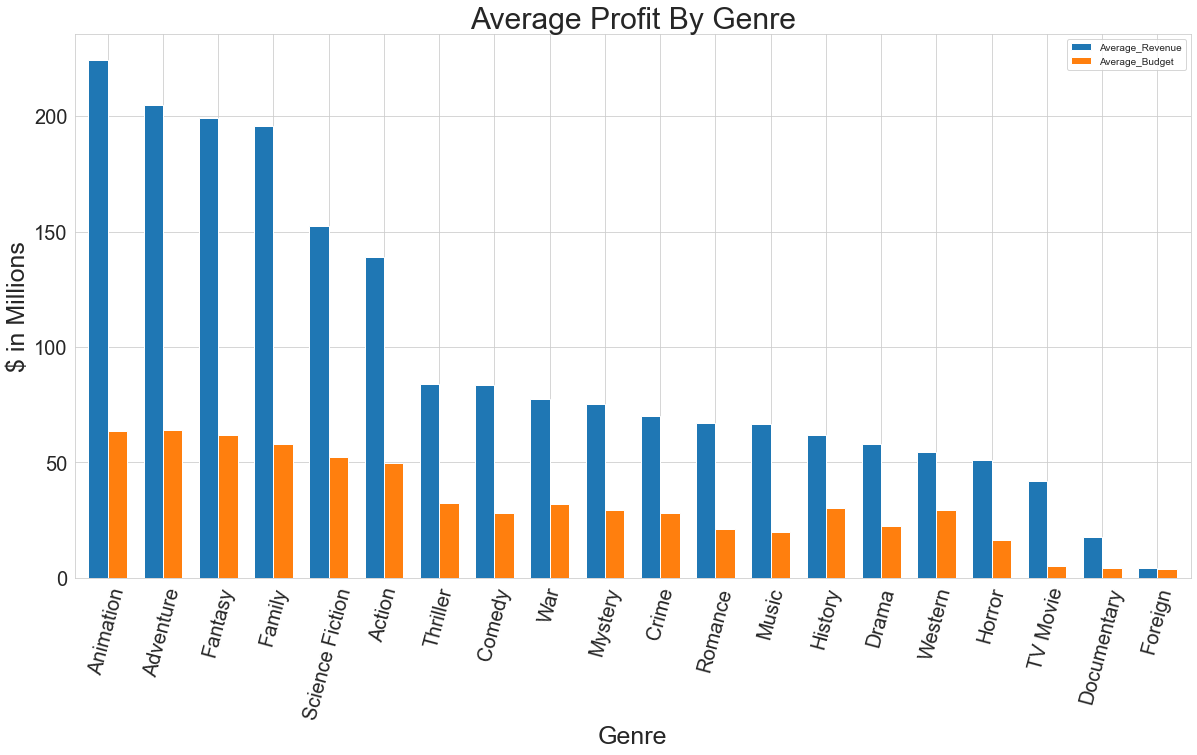

In [52]:
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Average_Revenue',ascending=False)

f,ax=plt.subplots(figsize=(20, 10))
chart = expinfodf_by_genre[["Genre","Average_Revenue","Average_Budget"]].plot.bar(x='Genre',width=0.7,rot=75,ax=ax,fontsize=20)
chart.set_ylabel("$ in Millions",fontsize=25)
chart.set_xlabel("Genre", fontsize=25)
chart.set_title("Average Profit By Genre",fontsize=30)


This is a double-column bar chart that takes in the average revenue and budget, in millions of dollars, by the movies in each genre. The average profit is equal to the average budget subtracted from the average revenue, therefore the gap in between the 2 columns for each genre represents the average profit made for that genre. We can see that every genre makes some sort of profit, except for the foreign and TV movie genres. This is because the average budget for these genres exceeds the average revenue made, making the movies that are in these genres the least profitable. The most profitable genres to make movies fall into Animation, Adventure, Family, and Fantasy, which all have at least 90 million dollars’ worth of average profit. To the right of the Action genre, all of the genres tend to have at most 60 million dollars of average revenue and at most 30 million dollars of average budget, and this section makes up the majority of all the genres.

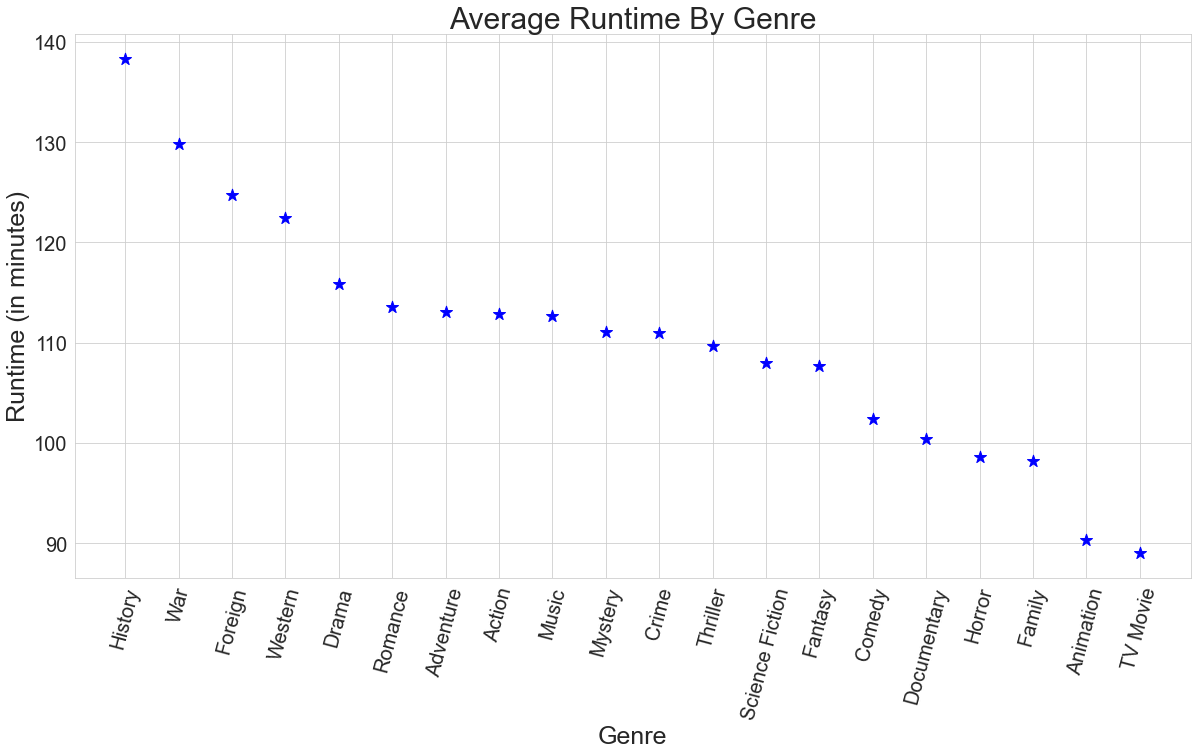

In [53]:

expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Average_Runtime',ascending=False)

f,ax=plt.subplots(figsize=(20, 10))
expinfodf_by_genre.plot(kind="scatter",x='Genre',y='Average_Runtime',ax=ax,s=160, c='b', marker='*')
plt.yticks(fontsize=20)
plt.xticks(rotation=75,fontsize=20)
plt.xlabel('Genre',fontsize=25)
plt.ylabel("Runtime (in minutes)",fontsize=25)
plt.title('Average Runtime By Genre',fontsize=30)
plt.show()


This is a scatterplot of the average runtime from all the movies within each genre. Runtime is the length of a movie in minutes. From the plot, we can tell that the history and war genres have a higher average runtime than the rest of the genres, and on the contrary we can see that animation has a significantly lower average runtime than every other genre. The rest of the genres follow a general trend of having anywhere from roughly 90 to 105 minutes of average runtime.

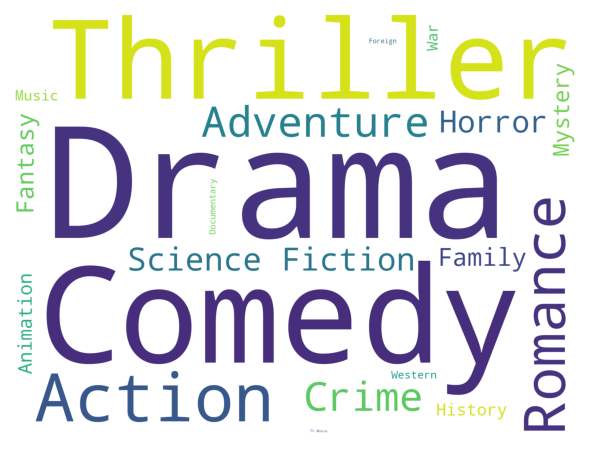

In [114]:
# wordcloud of genres by count of movies per genre
expinfodf_by_genre = expinfodf_by_genre.sort_values(by='Movie_Count_Genre',ascending=False)


genre_wordcloud=WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)
count = get_moviescount_for_wordcloud(expinfodf_by_genre)
genre_wordcloud.generate_from_frequencies(count)
f, ax = plt.subplots(figsize=(16, 8))
plt.axis('off')
plt.imshow(genre_wordcloud)
plt.show()
genre_wordcloud.to_file("images/wordCloud_genre.png")

This is word cloud that takes the total number of movies by genre, and results in a variation of genre name sizes that correspond to the number of movies. When there is a higher total count of movies, the genre name will appear larger. From this data, we can see that throughout the history of cinema, comedy, drama, and thriller movies have the greatest number of movies for any genre. Crime, adventure, romance, action, and horror all have roughly the same number of movies produced. And then genres like documentary, foreign, and western seem to have very few movies associated with them.

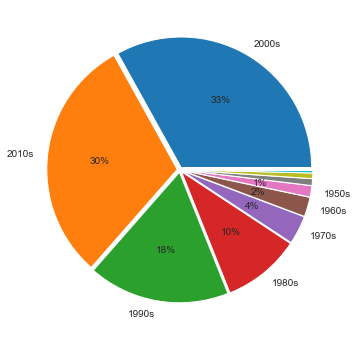

In [44]:
# numbers of movies released in each decade
series = movies_cbr_small.release_date.dropna().apply(lambda x:str(x.year//10*10)+'s')

counts=series.value_counts()
counts = counts/counts.sum()
labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
f, ax = plt.subplots(figsize=(6, 6))
explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
plt.show()


This is a pie chart representing the number of movies released in each decade. The percentages show how much of the total number of movies in history, were released during that specific decade. Overall, we can see a trend that as we continue along each decade, the number of movies released increases, making that decade a larger part of the pie. This means throughout time; the movie industry has only been growing larger and larger.

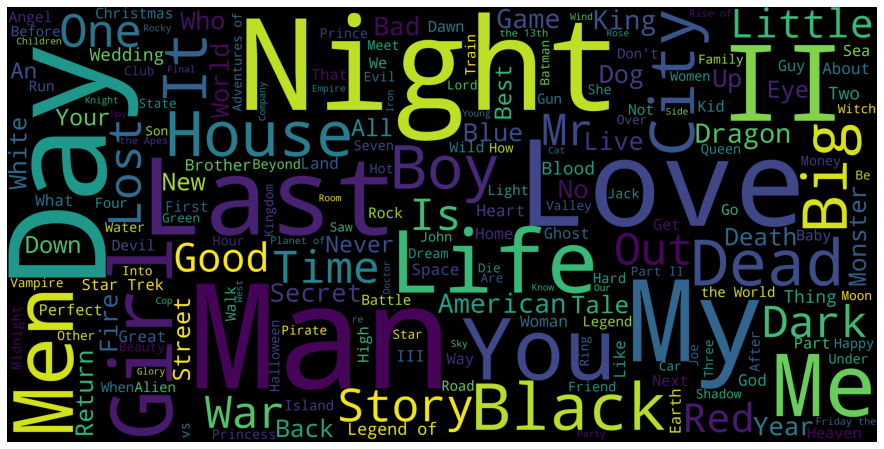

In [110]:
# Create a wordcloud of the movie titles
movies_cbr_small['title'] = movies_cbr_small['title'].fillna("").astype('str')
title_corpus = ' '.join(movies_cbr_small['title']).replace("The","").replace("Movie","")

# Plot the wordcloud
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()
title_wordcloud.to_file("images/wordCloud_title.png")

This is a word cloud that takes in the total count of every word in every movie title, and displays the most common words. It shows those words in varying sizes that correspond with the total count of that word. When there is a higher total count of that word, that word will appear larger. Aside from the word "The", the most common words for movie titles include "Day","Night","Man","Love", etc. Phrases of movie titles can also appear in the word cloud, like "The Last". We can also see that words like "II" show up large as well, which makes sense since many movies have sequels after them.